In [106]:
# Reading files 
import os
from pathlib import Path

# Image Preprocessing 
import cv2 as cv2
from PIL import Image
import matplotlib.image as mpimg
from tensorflow.keras.utils import img_to_array

# Data Manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# EDA 
import seaborn as sns
import matplotlib.pyplot as plt
#from collections import Counter

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# callbacks, save, load, and evaluate the model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Root Directory**

In [22]:
rootDirectory = Path('/content/drive/MyDrive/samples/')

# I. EDA

**1. How many different extensions we have for the images?**

In [23]:
# Get list of all PNG images
png_images = list(rootDirectory.glob("*.png"))
print("Number of png images found: ", len(png_images))


# Get list of all JPG the images
jpg_images = list(rootDirectory.glob("*.jpg"))
print("Number of jpg images found: ", len(jpg_images))

Number of png images found:  1070
Number of jpg images found:  0


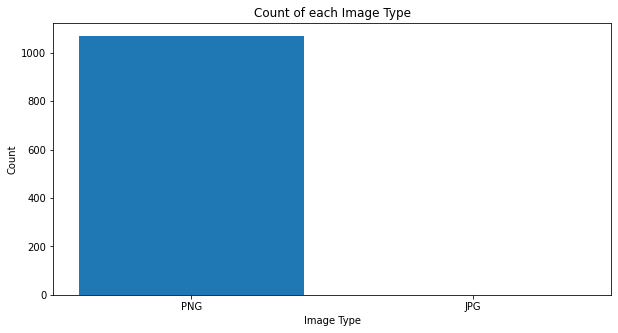

In [24]:
image_type = ['PNG','JPG']
count = [len(png_images), len(jpg_images)]

fig=plt.figure(figsize=(10, 5))
plt.bar(image_type, count)
plt.title('Count of each Image Type')
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.show()

**2. How the files are structured? Whats the difference between .png and .jpg? Do we need to standardize their shapes** 

🚫 dont run until you upload the new folder

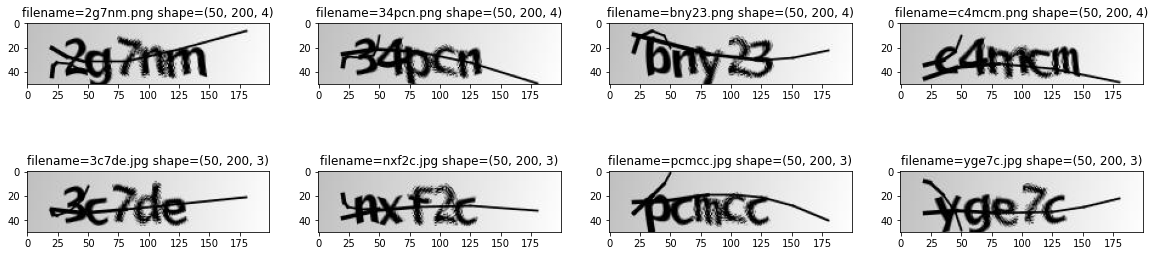

In [ ]:
img_2g7nm = mpimg.imread(rootDirectory + '2g7nm.png')
img_34pcn = mpimg.imread(rootDirectory + '34pcn.png')
img_bny23 = mpimg.imread(rootDirectory + 'bny23.png')
img_c4mcm = mpimg.imread(rootDirectory + 'c4mcm.png')
img_3c7de = mpimg.imread(rootDirectory + '3c7de.jpg')
img_nxf2c = mpimg.imread(rootDirectory + 'nxf2c.jpg')
img_pcmcc = mpimg.imread(rootDirectory + 'pcmcc.jpg')
img_yge7c = mpimg.imread(rootDirectory + 'yge7c.jpg')
samples = {'2g7nm.png':img_2g7nm, '34pcn.png':img_34pcn, 'bny23.png':img_bny23, 'c4mcm.png':img_c4mcm, 
           '3c7de.jpg':img_3c7de, 'nxf2c.jpg':img_nxf2c, 'pcmcc.jpg':img_pcmcc, 'yge7c.jpg':img_yge7c}

fig=plt.figure(figsize=(20, 5))
pos = 1
for filename, img in samples.items():
    fig.add_subplot(2, 4, pos)
    pos = pos+1
    plt.imshow(img)
    plt.title('filename='+filename+' shape='+str(img.shape))
plt.show()

- Each file is an image representing a CAPTCHA image.
The image is either in png format (1040 png files) or in jpg format (30 jpg files).
The file name is composed of the 5 characters contained in the CAPTCHA image followed by the image format (e.g. 2g7nm.png)

- Each image has 50x200 pixels. That said, the shape of the array differs between jpg and png images indicating that jpg images are RGB and png are RGBA. Since images are black & white, R, G and B are all similar. Also for png images, there is no differecence in transparency (alpha is always 1).

**3. How many letters/numbers we have in our dataset?**

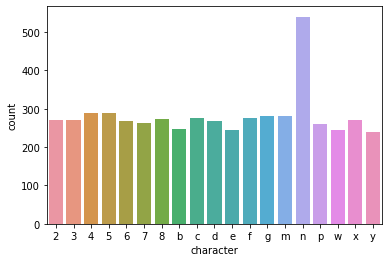

In [25]:
df = pd.DataFrame(columns=['filename','extension','label','labelsize','char1','char2','char3','char4','char5'])
i = 0
for _, _, files in os.walk(rootDirectory):
    for f in files:
        # extracting the file name
        df.loc[i,'filename'] = f
        # extracting the extension of the image
        df.loc[i,'extension'] = f.split('.')[1]
        # extracting the name (label) of the image
        df.loc[i,'label'] = f.split('.')[0]
        # we need to make sure that all the labels are of the same size (important for the input shape)
        df.loc[i,'labelsize'] = len(f.split('.')[0])
        # saving all the 5 charachters we have in each label, in order to count them
        df.loc[i,'char1'] = f.split('.')[0][0]
        df.loc[i,'char2'] = f.split('.')[0][1]
        df.loc[i,'char3'] = f.split('.')[0][2]
        df.loc[i,'char4'] = f.split('.')[0][3]
        df.loc[i,'char5'] = f.split('.')[0][4]
        i = i+1
        
# (H x W x RGB 3 color channels)
# looping through the images in our dataset, counting the charachters we have, and spotiiing the difference between the .png and jpg
data = pd.DataFrame(df['char1'].value_counts()+df['char2'].value_counts()+df['char3'].value_counts()+df['char4'].value_counts()+df['char5'].value_counts()).reset_index()
data.columns = ['character','count']

sns.barplot(data=data, x='character', y='count')
plt.show()

In [26]:
df.head(10)

,filename,extension,label,labelsize,char1,char2,char3,char4,char5
0,34fxm.png,png,34fxm,5,3,4,f,x,m
1,33n73.png,png,33n73,5,3,3,n,7,3
2,3b4we.png,png,3b4we,5,3,b,4,w,e
3,33f7m.png,png,33f7m,5,3,3,f,7,m
4,34pcn.png,png,34pcn,5,3,4,p,c,n
5,3ym7f.png,png,3ym7f,5,3,y,m,7,f
6,3eny7.png,png,3eny7,5,3,e,n,y,7
7,3dgmf.png,png,3dgmf,5,3,d,g,m,f
8,3ebpw.png,png,3ebpw,5,3,e,b,p,w
9,3n7mx.png,png,3n7mx,5,3,n,7,m,x


In [27]:
data

,character,count
0,2,270
1,3,271
2,4,289
3,5,288
4,6,267
5,7,262
6,8,272
7,b,247
8,c,276
9,d,269




Now, looking at the characters in the CAPTCHA images, one can notice that:

* only 19 characters are used 2, 3, 4, 5, 6, 7, 8 and b, c, d, e, f, g, m, n, p,w, x, y
* the frequency of each character is roughly the same with one exception: **n** is used twice often than other characters

# II. Preproccessing

## 1. Changing all Image Extensions from JPG to PNG

In [28]:
for filename in os.listdir(rootDirectory):
  # for each file that ends with a .jpg --> extract only the name of the label, and convert the extention to .png
  if filename.endswith(".jpg"):
      prefix = filename.split(".jpg")[0]
      os.rename(rootDirectory + filename, rootDirectory + prefix + ".png")
  else: 
    continue

In [29]:
# Get list of all PNG images
png_images = list(rootDirectory.glob("*.png"))
print("Number of png images found: ", len(png_images))

Number of png images found:  1070


## 2. Plot Two Sample Images **Before** Preprocessing 
 


In [36]:
path1 = '/content/drive/MyDrive/samples/23n88.png'
path2 = '/content/drive/MyDrive/samples/23mdg.png'

In [38]:
def plot_ (img1, img2) :
    plt.figure(figsize = (20,5))
    
    plt.subplot(1,2,1)
    plt.imshow(img1, 'gray')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(img2, 'gray')
    plt.axis('off')

In [39]:
img_1 = cv2.imread(path1)
img_2 = cv2.imread(path2)

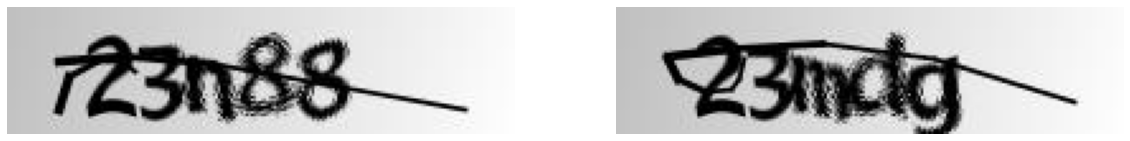

In [40]:
plot_(img_1, img_2)

##3. Convert to GrayScale

In [41]:
img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

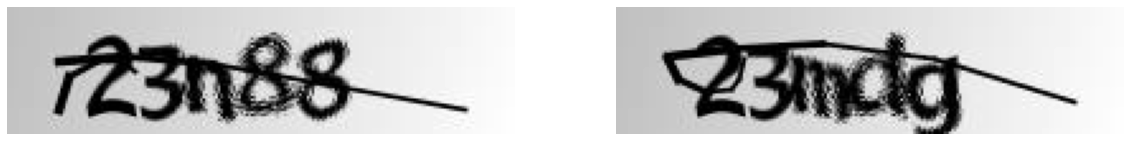

In [42]:
plot_(img1, img2)

##4. Adaptive Thresholding
#### Algorithms determine the threshold for a pixel based on its surrounding regions. So we get different thresholds for different regions of the same image which gives better result for images with varying illumination.

In [43]:
thresh_img1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
thresh_img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

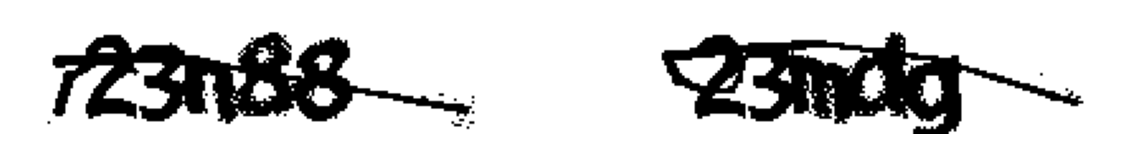

In [44]:
plot_(thresh_img1, thresh_img2)

##5. Closing
#### Dilation followed by Erosion.

In [63]:
close_img1 = cv2.morphologyEx(thresh_img1, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))
close_img2 = cv2.morphologyEx(thresh_img2, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

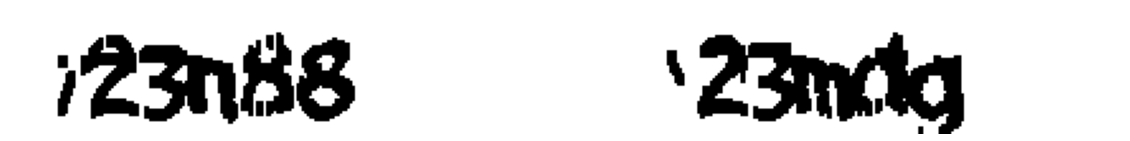

In [64]:
plot_(close_img1, close_img2)

##6. Dilation
#### Involves a kernel being scanned over the entire image. The maximal pixel value is calculated in the kernel region and the anchor point of the kernel is updated to that value. This causes the white region to expand in the image.

In [47]:
dilate_img1 = cv2.dilate(close_img1, np.ones((2,2), np.uint8), iterations = 1)
dilate_img2 = cv2.dilate(close_img2, np.ones((2,2), np.uint8), iterations = 1)

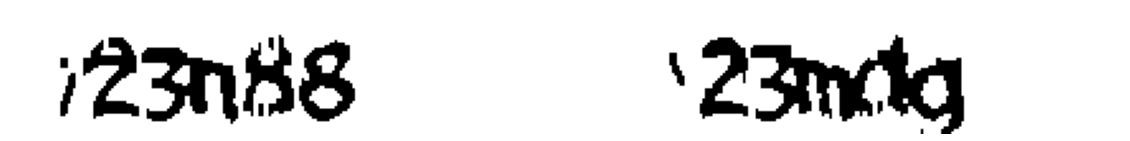

In [48]:
plot_(dilate_img1, dilate_img2)

##7. Smoothing Images (Blurring)
#### Involves convolving a low-pass filter with an image, to remove high frequency components ie. noises and edges from the image.

In [49]:
gauss_img1 = cv2.GaussianBlur(dilate_img1, (1,1), 0)
gauss_img2 = cv2.GaussianBlur(dilate_img2, (1,1), 0)

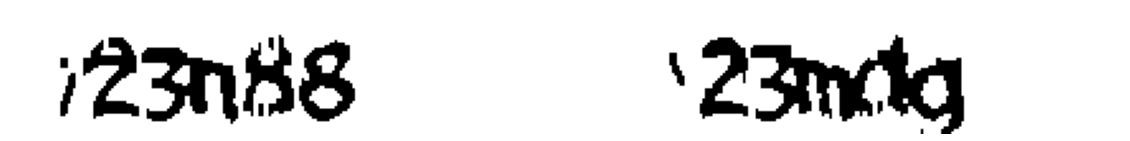

In [50]:
plot_(gauss_img1, gauss_img2)

##8. Combining all Image Preprocessing Steps:
1. Convert to Grayscale
2. Adaptive Thresholding
3. Closing
4. Dilation
5. Smoothing Images (Blurring)

In [53]:
def t_img (img) :
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)

def c_img (img) :
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5,2), np.uint8))

def d_img (img) :
    return cv2.dilate(img, np.ones((2,2), np.uint8), iterations = 1)

def b_img (img) :
    return cv2.GaussianBlur(img, (1,1), 0)

* Can take some time...

In [58]:
for image in os.listdir(rootDirectory) : 
    picture = cv2.imread(os.path.join("/content/drive/MyDrive/samples/", image), cv2.IMREAD_GRAYSCALE)
    picture = t_img(picture)
    picture = c_img(picture)
    picture = d_img(picture)
    picture = b_img(picture)
    picture = cv2.imwrite(os.path.join("/content/drive/MyDrive/edited_samples/", image), picture)

In [61]:
new_dir = "/content/drive/MyDrive/edited_samples/"
new_dir

'/content/drive/MyDrive/edited_samples/'

## 9. Plot two Sample Images **After** the Final Preprocessing 
 


In [65]:
path1 = '/content/drive/MyDrive/edited_samples/2356g.png'
path2 = '/content/drive/MyDrive/edited_samples/245y5.png'

In [66]:
def plot_ (img1, img2) :
    plt.figure(figsize = (20,5))
    
    plt.subplot(1,2,1)
    plt.imshow(img1, 'gray')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(img2, 'gray')
    plt.axis('off')

In [67]:
img_1 = cv2.imread(path1)
img_2 = cv2.imread(path2)

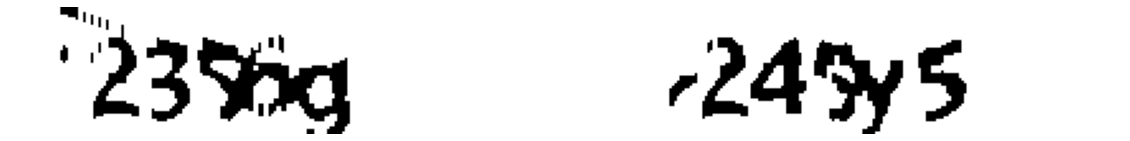

In [68]:
plot_(img_1, img_2)

# III. Split and Label Encoding
(Create lists for X: Images, Y: Labels)

This section generates the training set that will be used to train the neural network and the test set that will be used to evaluate the model performance.

The training set will have 90% of the data:

* X_train with 963 images. X_train shape will be (963, 50, 200, 1)
* y_train with 963 labels. y_train shape will be (963, 5)

The test set will have 10% of the data:

* X_test with 107 images. X_val shape will be (107, 50, 200, 1)
* y_test with 107 labels. y_val shape will be (107, 5)

The label corresponding to each image is a string corresponding to the filename minus the extension. **As the neural net deals only with numerical values, we will have to map each character in the string to an integer.**

Caesar Cipher? Something like this 💯

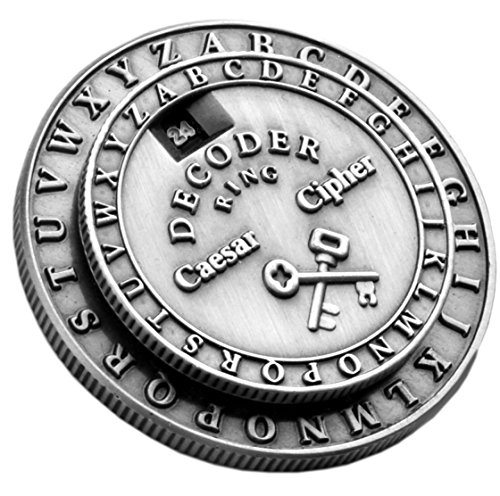

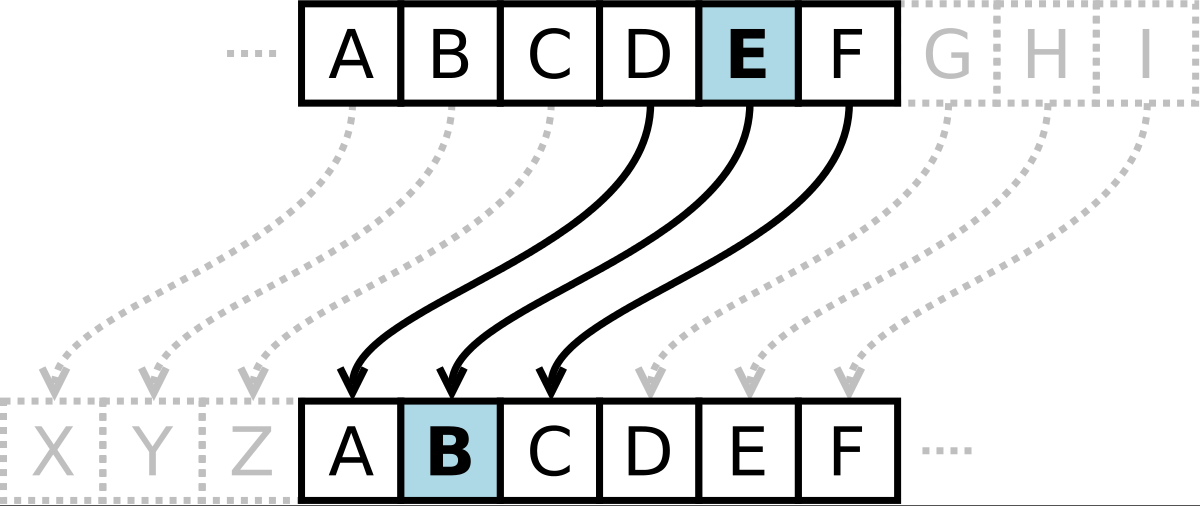

In [71]:
# Dictionaries that will be used to convert characters to integers and vice-versa
vocabulary = {'2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y'}
char_to_num = {'2':0,'3':1,'4':2,'5':3,'6':4,'7':5,'8':6,'b':7,'c':8,'d':9,'e':10,'f':11,'g':12,'m':13,'n':14,'p':15,'w':16,'x':17,'y':18}

In [97]:
##############################################################################################################################
# This function encodes a single sample. 
# Inputs:
# - img_path: the string representing the image path e.g. '/content/drive/MyDrive/edited_samples/6n6gg.png'
# - label: the string representing the label e.g. '6n6gg'
# - crop: boolean, if True the image is cropped around the characters and resized to the original size.
# Outputs:
# - a multi-dimensional array reprensenting the image. Its shape is (50, 200, 1)
# - an array of integers representing the label after encoding the characters to integer. E.g [6,16,6,14,14] for '6n6gg' 
##############################################################################################################################

def encode_single_sample(img_path, label, crop):
    # Read image file and returns a tensor with dtype=string
    img = tf.io.read_file(img_path)

    # Decode and convert to grayscale (this conversion does not cause any information lost and reduces the size of the tensor)
    # This decode function returns a tensor with dtype=uint8
    img = tf.io.decode_png(img, channels=1) # CHANNELS = 1 = greyscale

    # Scales and returns a tensor with dtype=float32
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Crop and resize to the original size: 
    # top-left corner = offset_height, offset_width in image = 0, 25 
    # lower-right corner is at offset_height + target_height, offset_width + target_width = 50, 150
    if(crop==True):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=25, target_height=50, target_width=125)
        img = tf.image.resize(img, size=[50, 200], method='bilinear', preserve_aspect_ratio=False, antialias=False, name=None) 
    # Transpose the image because we want the time dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # Converts the string label into an array with 5 integers. E.g. '6n6gg' is converted into [6,16,6,14,14]
    label = list(map(lambda x:char_to_num[x], label))
    return img.numpy(), label

In [101]:
root_Directory = '/content/drive/MyDrive/edited_samples/'

In [102]:
def create_train_and_test_datasets(crop=False):
    # Loop on all the files to create X whose shape is (1070, 50, 200, 1) and y whose shape is (1070, 5)
    X, y = [],[]
    for _, _, files in os.walk(root_Directory):
        for f in files:
            label = f.split('.')[0]
            extension = f.split('.')[1]
            # making sure again that the extension is .png
            if extension=='png':
                img, label = encode_single_sample(root_Directory + f, label, crop)
                X.append(img)
                y.append(label)

    X = np.array(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X.reshape(1070, 10000), y, test_size=0.1, shuffle=True, random_state=42)
    X_train, X_test = X_train.reshape(963, 200, 50, 1), X_test.reshape(107, 200, 50, 1)
    return X_train, X_test, y_train, y_test

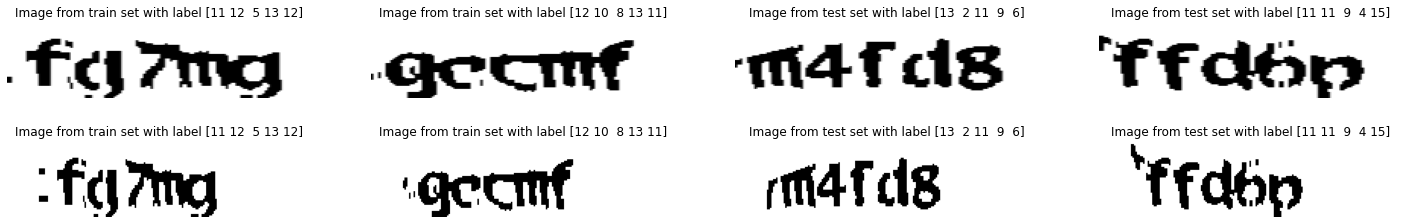

In [104]:
# images on the 1st row are transposed, cropped around the characters and resized 
X_train, X_test, y_train, y_test = create_train_and_test_datasets(crop=True)

fig=plt.figure(figsize=(25, 4))
fig.add_subplot(2, 4, 1)
#plt.imshow(X_train[0], cmap='gray')
plt.imshow(X_train[0].reshape(200, 50).transpose(), cmap='gray')
plt.title('Image from train set with label '+ str(y_train[0]))
plt.axis('off')
fig.add_subplot(2, 4, 2)
#plt.imshow(X_train[935], cmap='gray')
plt.imshow(X_train[935].reshape(200, 50).transpose(), cmap='gray')
plt.title('Image from train set with label '+ str(y_train[935]))
plt.axis('off')
fig.add_subplot(2, 4, 3)
#plt.imshow(X_val[0], cmap='gray')
plt.imshow(X_test[0].reshape(200, 50).transpose(), cmap='gray')
plt.title('Image from test set with label '+ str(y_test[0]))
plt.axis('off')
fig.add_subplot(2, 4, 4)
#plt.imshow(X_val[103], cmap='gray')
plt.imshow(X_test[103].reshape(200, 50).transpose(), cmap='gray')
plt.title('Image from test set with label '+ str(y_test[103]))
plt.axis('off')

#images on the 2nd row are transposed only 
X_train_, X_test_, y_train_, y_test_ = create_train_and_test_datasets(crop=False)

fig.add_subplot(2, 4, 5)
#plt.imshow(X_train_[0], cmap='gray')
plt.imshow(X_train_[0].reshape(200, 50).transpose(), cmap='gray')
plt.title('Image from train set with label '+ str(y_train_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 6)
#plt.imshow(X_train_[935], cmap='gray')
plt.imshow(X_train_[935].reshape(200, 50).transpose(), cmap='gray')
plt.title('Image from train set with label '+ str(y_train_[935]))
plt.axis('off')
fig.add_subplot(2, 4, 7)
#plt.imshow(X_val_[0], cmap='gray')
plt.imshow(X_test_[0].reshape(200, 50).transpose(), cmap='gray')
plt.title('Image from test set with label '+ str(y_test_[0]))
plt.axis('off')
fig.add_subplot(2, 4, 8)
#plt.imshow(X_val_[103], cmap='gray')
plt.imshow(X_test_[103].reshape(200, 50).transpose(), cmap='gray')
plt.title('Image from test set with label '+ str(y_test_[103]))
plt.axis('off')
plt.show()

As we can see, when the images are  transposed, cropped around the characters and resized, its better for the model and even for the human eye to see.

🎆 Lets encode one of the samples..


```
'2':0 -- '3':1 -- '4':2 -- '5':3 -- '6':4 -- '7':5 -- '8':6 -- 'b':7 
'c':8 -- 'd':9 -- 'e':10 -- 'f':11 'g':12 -- 'm':13 -- 'n':14 -- 'p':15 
'w':16 -- 'x':17 -- 'y':18
```


fg7mg --> [11 12 5 13 12]

```
f -> 11

g -> 12

7 -> 5 

m -> 13

g -> 12
```

This solution solution combines a CNN and a FC Classifier and achieves pretty good performance (>94%). It :

crops the image around the characters and flips the cropped image (as we want the time dimension to correspond to the width of the image).
uses a CNN to extract features from the cropped image.
reshapes the features to "split" them into 5 time-steps.
uses a FC Classifier to predict 5 characters : for each time-step, the output is the probability distribution of a character being at this step.

# IV. Build and Train the Model

In [105]:
def build_model():
    
    # Inputs to the model
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 

    # First conv block
    x = layers.Conv2D(32,(3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64 --> output volume shape = (50,12,64) 
    # Reshape to "split" the volume in 5 time-steps
    x = layers.Reshape(target_shape=(5, 7680), name="reshape")(x)
    # Fully Connected layers
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(64, activation="relu", name="dense2")(x)
   
    # Output layer
    output = layers.Dense(19, activation="softmax", name="dense3")(x) 
    
    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=output, name="CAPTCHA_classifier")
    
    # Compile the model and return
    # sparse: becuase we have integer targets
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
    return model


# Get the model
model = build_model()
model.summary()

Model: "CAPTCHA_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 5, 7680)           0         
                                                                 
 dense1 (Dense)              (None, 5, 256)     

In [108]:
checkp = ModelCheckpoint('/content/drive/MyDrive/models/w6_model_p.h5', monitor = 'loss', verbose = 1, save_best_only = True)

In [109]:
reduce = ReduceLROnPlateau(monitor = 'loss', patience = 20, verbose = 1)

In [110]:
X_train, X_val, y_train, y_val = create_train_and_test_datasets(crop=True)
history = model.fit(x=X_train, y=y_train, epochs=30, callbacks = [checkp])

Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 2.4692 - accuracy: 0.2777
Epoch 1: loss improved from inf to 2.46919, saving model to /content/drive/MyDrive/models/w6_model_p.h5
31/31 [==============================] - 16s 463ms/step - loss: 2.4692 - accuracy: 0.2777
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 0.8384 - accuracy: 0.7637
Epoch 2: loss improved from 2.46919 to 0.83838, saving model to /content/drive/MyDrive/models/w6_model_p.h5
31/31 [==============================] - 15s 471ms/step - loss: 0.8384 - accuracy: 0.7637
Epoch 3/30
31/31 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.8812
Epoch 3: loss improved from 0.83838 to 0.41411, saving model to /content/drive/MyDrive/models/w6_model_p.h5
31/31 [==============================] - 15s 469ms/step - loss: 0.4141 - accuracy: 0.8812
Epoch 4/30
31/31 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.9325
Epoch 4: loss improved from 0.4141

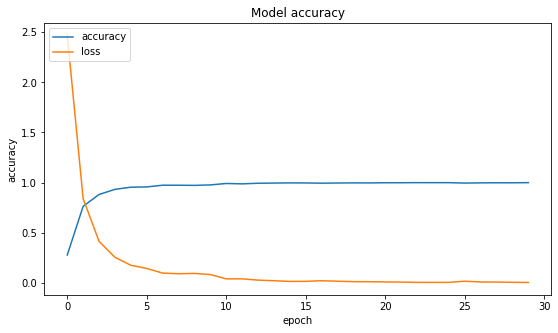

In [112]:
fig=plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')

# V. Decoding the Predictions

In [113]:
y_pred = model.predict(X_test) # y_pred shape = (104,50,19)
y_pred = np.argmax(y_pred, axis=2)

4/4 [==============================] - 1s 100ms/step


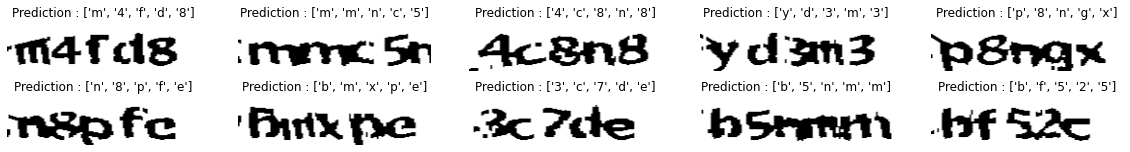

In [199]:
# char_to_num = {'2':0,'3':1,'4':2,'5':3,'6':4,'7':5,'8':6,'b':7,'c':8,'d':9,'e':10,'f':11,'g':12,'m':13,'n':14,'p':15,'w':16,'x':17,'y':18}
num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}
nrow = 1
#fig=plt.figure(figsize=(25, 3))
fig=plt.figure(figsize=(20, 5))
for i in range(10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_test[i].reshape(200,50).transpose(),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show() 

We will assess the performance of the different models on the test dataset that contains 10% of the complete dataset.

For each image in the test set, we will compare the true label with the prediction. The true label and the prediction are (5,1) vectors. Therefore we will compare the vectors element-wise and count the number of good predictions element-wise. For each image, the score will be (nb of good predictions element-wise)/5

E.g. :

* the true label corresponding to the image 368y5.png is [1 4 6 18 3] (after transforming the characters to numerical values)
* if the predicted label is [1 4 6 18 3], then the score for this image is 1 --> all of them are true
* if the predicted label is [2 6 4 10 1], then the score for this image is 0 --> all of them are wrong
* if the predicted label is [1 6 6 10 1], then the score for this image is 0.4 (2 characters correctly predicted) (2/5)*100

The performance of the model will be the average of the scores for each image in the test set. This number corresponds to the percentage of characters that are correctly predicted.

In [115]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
                      # boolean list of matching letters / 107 * 5 
                      # 509 / 535 = 0.95
        return np.sum(predictions == groundtruth)/(predictions.shape[0]*predictions.shape[1])
    else:
        raise Exception('Error : the size of the arrays do not match. Cannot compute the performance metric')

Let's use the function compute_perf_metric to calculate the performance metric of this model. Reminder : this metric corresponds to the percentage of characters that are correctly predicted (and this % is calculated using the 107 images hence 535 characters of the test set).

In [198]:
compute_perf_metric(y_pred, y_test)

0.9514018691588785

#### stuff

In [131]:
y_pred.shape == y_test.shape

True

In [138]:
y_pred == y_test

array([[ True,  True,  True,  True,  True],
       [ True,  True, False, False, False],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True, False,  True,  True],
       [ True,  True,  True, False,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  Tr

In [136]:
np.sum(y_pred == y_test)

509

In [139]:
y_pred.shape

(107, 5)

In [133]:
y_pred.shape[0]

107

In [137]:
y_pred.shape[1]

5

In [135]:
y_pred.shape[0]*y_pred.shape[1]

535

# VI. Loading the Saved Model for Breaking a new CAPTCHA

In [234]:
model = load_model('/content/drive/MyDrive/models/w6_model_p.h5')

In [235]:
y_pred = model.predict(X_test) # y_pred shape = (104,50,19)
y_pred = np.argmax(y_pred, axis=2)

4/4 [==============================] - 1s 106ms/step


In [236]:
# looping through our test set to take the names of the label and plot some samples prediction
for i in range(107):
  print(str(list(map(lambda x:num_to_char[str(x)], y_test[i]))))

['m', '4', 'f', 'd', '8']
['m', 'm', 'c', '5', 'n']
['4', 'c', '8', 'n', '8']
['y', 'd', '3', 'm', '3']
['p', '8', 'n', 'g', 'x']
['n', '8', 'p', 'f', 'e']
['b', 'm', 'x', 'p', 'e']
['3', 'c', '7', 'd', 'e']
['b', '5', 'n', 'm', 'm']
['b', 'f', '5', '2', 'c']
['5', 'n', 'p', 'd', 'n']
['6', '5', 'm', '8', '5']
['g', 'b', 'x', 'y', 'y']
['p', 'c', 'm', 'c', 'c']
['7', '7', '3', '8', '7']
['8', 'b', 'b', 'w', '8']
['f', 'd', 'p', 'g', 'd']
['5', '6', 'n', 'c', 'x']
['n', 'g', '2', 'g', 'w']
['8', 'n', 'p', 'd', '5']
['b', 'b', 'y', 'm', 'y']
['e', '4', '6', 'p', 'd']
['4', 'n', '2', 'y', 'g']
['d', 'd', 'n', 'p', 'f']
['w', 'd', 'w', 'w', '8']
['f', 'w', 'x', 'd', 'p']
['2', 'p', 'f', 'p', 'n']
['3', 'b', 'n', 'y', 'f']
['g', 'c', 'f', 'g', 'p']
['f', 'c', 'e', 'y', '3']
['n', 'e', 'e', 'c', 'd']
['e', '7', '2', 'c', 'd']
['5', 'n', 'g', '6', 'e']
['x', 'f', 'g', '6', '5']
['m', 'm', '3', 'n', 'n']
['g', 'm', '6', 'n', 'n']
['m', 'x', '8', 'b', 'b']
['3', 'p', 'e', '4', 'g']
['n', 'y', '

In [237]:
def get_demo (img_path):
    # this function will perform the same preprocessing steps we did before, but will accept unprocessed images
    # from the test set. Show the unprocessed image next to the processed one and prints the predicted label next to the actual label
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1) # CHANNELS = 1 = greyscale
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=25, target_height=50, target_width=125)
    img = tf.image.resize(img, size=[50, 200], method='bilinear', preserve_aspect_ratio=False, antialias=False, name=None) 
    img = tf.transpose(img, perm=[1, 0, 2])

    Xdemo = []
    Xdemo.append(img_to_array(img))
    Xdemo = np.array(Xdemo)
    plt.imshow(Xdemo.reshape(200, 50).transpose(), 'gray')
    plt.axis('off')
    plt.show()
    ydemo = model.predict(Xdemo)
    ydemo = np.argmax(ydemo, axis = 2)
    for res in ydemo:
      print(str(list(map(lambda x:num_to_char[str(x)], res))))
    print(img_path[-9:])

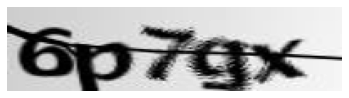

1/1 [==============================] - 0s 32ms/step
['6', 'p', '7', 'g', '6']
6p7gx.png


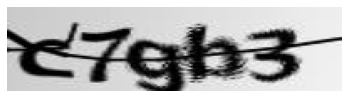

1/1 [==============================] - 0s 30ms/step
['c', '7', 'g', '6', '7']
c7gb3.png


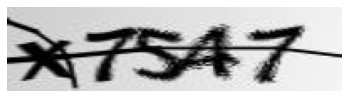

1/1 [==============================] - 0s 38ms/step
['e', '7', '7', 'f', '7']
x7547.png


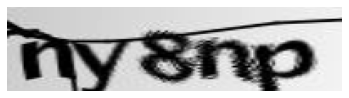

1/1 [==============================] - 0s 25ms/step
['n', 'y', '8', 'f', 'p']
ny8np.png


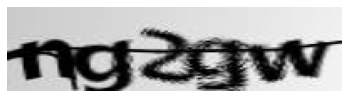

1/1 [==============================] - 0s 26ms/step
['n', 'g', '2', 'g', 'm']
ng2gw.png


In [238]:
get_demo('/content/drive/MyDrive/samples/6p7gx.png')
# 'c', '7', 'g', 'b', '3'
get_demo('/content/drive/MyDrive/samples/c7gb3.png')
# ['x', '7', '5', '4', '7']
get_demo('/content/drive/MyDrive/samples/x7547.png')
# ['n', 'y', '8', 'n', 'p']
get_demo('/content/drive/MyDrive/samples/ny8np.png')
# ['n', 'g', '2', 'g', 'w']
get_demo('/content/drive/MyDrive/samples/ng2gw.png')